In [1]:
import pandas as pd
import datetime
import numpy as np 
import pandas_datareader.data as web
from pandas import Series, DataFrame
from math import ceil 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
%matplotlib notebook

#Loading Yahoo Finance dataset
start = datetime.datetime(2009,1,1)
end = datetime.datetime(2019, 9, 1)

df = web.DataReader("AAPL", "yahoo", start, end)
#df.tail()

#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

#Comparing with other Companies
dfcomp = web.DataReader(['AMZN', 'TSLA', 'GOOGL', 'IBM', 'MSFT'],'yahoo',start=start,end=end)
retscomp = dfcomp.pct_change()

#finding Correlation
corr = retscomp.corr()

#feature engineering
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.fillna(value=-99999, inplace=True)
dfreg.dropna(inplace=True)

#we want to separate 1% of the data to forecast
forecast_out = int(ceil(.01 * len(dfreg)))

#separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

#Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

#Finally we want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

#DEFINING X_train before we use it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Polynomial Regression with 3 Features
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#Lasso Regression
clflasso = Lasso(alpha=0.1)
clflasso.fit(X_train,y_train)

#Ridge Regression
clfridge = Ridge(alpha=1.0)
clfridge.fit(X_train, y_train)

#let's evaluate all of the models against eachother
confidencereg = clfreg.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidencelasso = clflasso.score(X_test,y_test)
confidenceridge = clfridge.score(X_test,y_test)

# results
print("The accuracy for Linear Regression is: ",confidencereg)
print("The accuracy for Polynomial Regression with 3 Features is: ",confidencepoly3)
print("The accuracy for Lasso Regression is: ",confidencelasso)
print("The accuracy for Ridge Regression is: ",confidenceridge)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately)
forecast_set_poly3 = clfpoly3.predict(X_lately) 
forecast_set_lasso = clflasso.predict(X_lately)
forecast_set_ridge = clfridge.predict(X_lately)
dfreg['Forecast'] = np.nan


The accuracy for Linear Regression is:  0.9670917609538647
The accuracy for Polynomial Regression with 3 Features is:  0.9703878010749221
The accuracy for Lasso Regression is:  0.9671108228009946
The accuracy for Ridge Regression is:  0.967109983804024


In [2]:
#copying dataframe for forecasting individually
dfpoly= dfreg.copy()
dflasso = dfreg.copy()
dfridge = dfreg.copy()

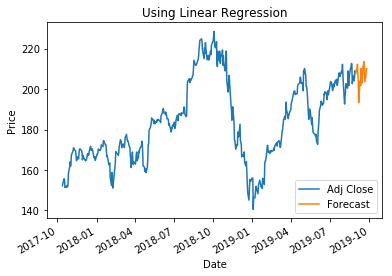

In [3]:
#results [Linear Regression]
#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: 
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.title('Using Linear Regression')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

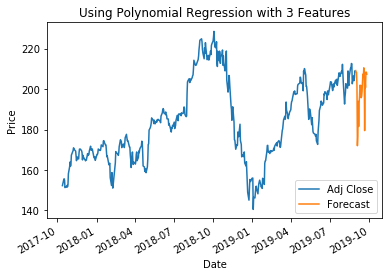

In [4]:
#results [Polynomial Regression]
#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dfpoly.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly3: 
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfpoly.loc[next_date] = [np.nan for _ in range(len(dfpoly.columns)-1)]+[i]

dfpoly['Adj Close'].tail(500).plot()
dfpoly['Forecast'].tail(500).plot()
plt.title('Using Polynomial Regression with 3 Features')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

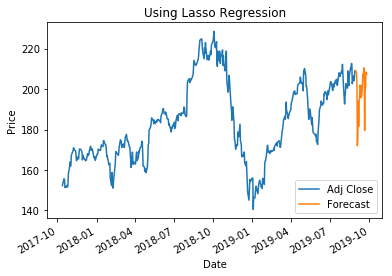

In [5]:
#results [Lasso Regression]
#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dflasso.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly3: 
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dflasso.loc[next_date] = [np.nan for _ in range(len(dflasso.columns)-1)]+[i]

dflasso['Adj Close'].tail(500).plot()
dflasso['Forecast'].tail(500).plot()
plt.title('Using Lasso Regression')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

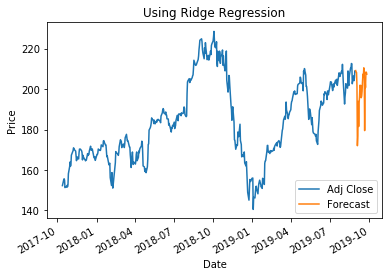

In [6]:
#results [Ridge Regression]
#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dfridge.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_poly3: 
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfridge.loc[next_date] = [np.nan for _ in range(len(dfridge.columns)-1)]+[i]

dfridge['Adj Close'].tail(500).plot()
dfridge['Forecast'].tail(500).plot()
plt.title('Using Ridge Regression')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()